In [1]:
import os
from glob import glob
import warnings

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
import rasterio as rio
from rasterio.plot import plotting_extent

import earthpy.spatial as es
import earthpy.plot as ep
import earthpy as et
import pyproj
import fiona

pyproj.set_use_global_context(True)


    
# Paths to data

path_to_drive = os.path.join("D:\\")
working_dir = os.path.join(path_to_drive, 'SpiritMound')

site_boundary_path = os.path.join(working_dir,
                                  'shapefiles',
                                  'spiritmound_boundary.shp')

test_data_path = os.path.join(working_dir,
                              "tar",
                              "LC08_L2SP_029030_20220315_20220322_02_T1",
                              "LC08_L2SP_029030_20220315_20220322_02_T1_SR_B4.tif")

all_data_path = os.path.join(working_dir,
                             "tar")
# Set working directory

if os.path.exists(working_dir):
    print("Path exists. Working directory set")
    os.chdir(working_dir)
else:
    print("Path does not exist. Creating and setting working directory")
    os.mkdirs(working_dir)
    os.chdir(working_dir)

# Create outputs directory
output_dir = os.path.join(working_dir, "outputs")
if os.path.exists(output_dir):
    print("Output directory exists")
else:
    print("Output directory does not exist, creating directory")
    os.mkdir(output_dir)

Path exists. Working directory set
Output directory exists


In [2]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )


def raster_specs(raster):
    specs = [raster.rio.shape,
             raster.rio.resolution(),
             raster.rio.crs,
             raster.rio.bounds()]
    return specs


def open_clean_bands(band_path,
                     site_bound,
                     variable=None,
                     valid_range=None,
                     ):

    band = rxr.open_rasterio(band_path,
                             masked=True,
                             variable=variable,
                             from_disk=True).rio.clip(geometries=site_bound,from_disk=True).squeeze()

    if valid_range:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band

def mask_ndvi(all_bands,
              vals,
              raster):
    """Open and mask a single landsat band using a pixel_qa layer.

    Parameters
    -----------
    all_bands : list
        A list containing two xarray objects for landsat bands 4 and  5
    vals: list
        A list of values needed to create the cloud mask


    Returns
    -----------
    ndvi_mask : Xarray Dataset
        a masked xarray object containing NDVI values
    """

    # Calculate NDVI
    ndvi_xr = (all_bands[1]-all_bands[0]) / (all_bands[1]+all_bands[0])

    # Apply cloud mask to NDVI
    ndvi_mask = ndvi_xr.where(~raster.isin(vals))

    return ndvi_mask
def mask_nbr(all_bands,
              vals,
              raster):
    """Open and mask a single landsat band using a pixel_qa layer.

    Parameters
    -----------
    all_bands : list
        A list containing two xarray objects for landsat bands 5 and  7
    vals: list
        A list of values needed to create the cloud mask


    Returns
    -----------
    nbr_mask : Xarray Dataset
        a masked xarray object containing NDVI values
    """

    # Calculate NBR
    nbr_xr = (all_bands[1]-all_bands[3]) / (all_bands[1]+all_bands[3])

    # Apply cloud mask to NDVI
    nbr_mask = nbr_xr.where(~raster.isin(vals))

    return nbr_mask

In [3]:
# Open Site Boundary
site_bound = gpd.read_file(site_boundary_path)
site_bound.crs

with fiona.open(site_boundary_path, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# Open one of the bands to view the data

raster = rxr.open_rasterio(test_data_path,
                           masked=True)


clip_ds = raster.rio.clip(geometries=shapes,
                             all_touched=True,
                             from_disk=True).squeeze()

print_raster(clip_ds)

shape: (56, 30)
resolution: (30.0, -30.0)
bounds: (666225.0, 4747965.0, 667125.0, 4749645.0)
sum: 19009164.0
CRS: EPSG:32614



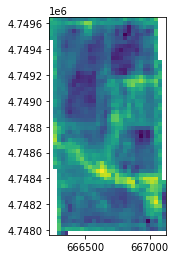

In [4]:
# View The open band
extents = plotting_extent(clip_ds.values,
                          clip_ds.rio.transform())

f, ax = plt.subplots()

im = ax.imshow(clip_ds,
               extent=extents)

plt.show()

In [5]:
# Get list of all the folders containing landsat datasets

dirs = glob(all_data_path + "/*/")

In [6]:
dirs

['D:\\SpiritMound\\tar\\LC08_L2SP_029030_20220315_20220322_02_T1\\',
 'D:\\SpiritMound\\tar\\LC08_L2SP_029030_20220416_20220420_02_T1\\',
 'D:\\SpiritMound\\tar\\LC08_L2SP_029030_20220518_20220525_02_T1\\',
 'D:\\SpiritMound\\tar\\LC09_L2SP_029030_20220408_20220520_02_T1\\']

In [7]:
# Open and process NDVI data
vals = [22280,
        24088, 24216, 24344, 24472, 55052, 56856, 56984, 57240]
ndvi_list=[]
date_list=[]
ndvi_plot=[]
for i in dirs:
    band_paths = sorted(glob(os.path.join(i, "*B*[4-5].tif")))

    pixel_qa_path = sorted(glob(os.path.join(i, "*QA_PIXEL*")))

    folder_name = os.path.basename(os.path.normpath(i))
    data_type_name = folder_name[0:4]
    date = folder_name[17:25]
    date_list.append(date)
    mean_ndvi_df = pd.DataFrame()
    out_xr = []
    out_pixel = []
    for band, tif_path in enumerate(band_paths):
        
        out_xr.append(open_clean_bands(band_path=tif_path,
                                       valid_range=(7273,43636),
                                       site_bound=shapes))

        out_xr[band]["band"] = band+1

    xr.concat(out_xr, dim="band")

    for k in pixel_qa_path:
        pixel_qa = rxr.open_rasterio(k, masked=True).rio.clip(geometries=shapes,
                                                                      from_disk=True).squeeze()
        ndvi = mask_ndvi(all_bands=out_xr,
                         vals=vals,
                         raster=pixel_qa)

        file_name = data_type_name + date + '.tif'
        out_path = os.path.join(output_dir, file_name)

        ndvi_clip = ndvi.rio.clip(geometries=shapes,
                                  all_touched=True,
                                  from_disk=True).squeeze()
        mean_ndvi=np.nanmean(ndvi_clip)
        ndvi_list.append(mean_ndvi)
        mean_ndvi_df["date"] = date_list
        mean_ndvi_df['mean_ndvi'] = ndvi_list
        
        ndvi_plot.append(ndvi_clip)
        ndvi_clip.rio.to_raster(out_path)
        

In [8]:
# Open process NBR data
vals = [22280,
        24088, 24216, 24344, 24472, 55052, 56856, 56984, 57240]
nbr_list=[]
date_list=[]
nbr_plot=[]
for i in dirs:
    band_paths = sorted(glob(os.path.join(i, "*B*[4-7].tif")))

    pixel_qa_path = sorted(glob(os.path.join(i, "*QA_PIXEL*")))

    folder_name = os.path.basename(os.path.normpath(i))
    data_type_name = folder_name[0:4]
    date = folder_name[17:25]
    date_list.append(date)
    mean_nbr_df = pd.DataFrame()
    out_xr = []
    out_pixel = []
    for band, tif_path in enumerate(band_paths):
        
        out_xr.append(open_clean_bands(band_path=tif_path,
                                       valid_range=(7273,43636),
                                       site_bound=shapes))

        out_xr[band]["band"] = band+1

    xr.concat(out_xr, dim="band")

    for k in pixel_qa_path:
        pixel_qa = rxr.open_rasterio(k, masked=True).rio.clip(geometries=shapes,
                                                                      from_disk=True).squeeze()
        nbr = mask_nbr(all_bands=out_xr,
                         vals=vals,
                         raster=pixel_qa)

        file_name = data_type_name + date + '_nbr'+'.tif'
        out_path = os.path.join(output_dir, file_name)

        nbr_clip = nbr.rio.clip(geometries=shapes,
                                  all_touched=True,
                                  from_disk=True).squeeze()
        mean_nbr=np.nanmean(nbr_clip)
        nbr_list.append(mean_nbr)
        mean_nbr_df["date"] = date_list
        mean_nbr_df['mean_nbr'] = nbr_list
        
        nbr_plot.append(nbr_clip)
        nbr_clip.rio.to_raster(out_path)

In [9]:
# GET RGB Image

rgb_plot=[]
for i in dirs:
    band_paths = sorted(glob(os.path.join(i, "*B*[2-4].tif")))

    

    folder_name = os.path.basename(os.path.normpath(i))
    data_type_name = folder_name[0:4]
    date = folder_name[17:25]
    date_list.append(date)
    
   
    file_name = data_type_name + date + '_rgb_cropped'+'.tif'
    out_path = os.path.join(output_dir, file_name)
    cropped_path = os.path.join(working_dir,"cropped")
    band_paths_list = es.crop_all(band_paths,cropped_path, shapes, overwrite=True)
    cropped_array, array_raster_profile = es.stack(band_paths_list,out_path=out_path)
    
    rgb_plot.append(cropped_array)
    
    
        
        
        

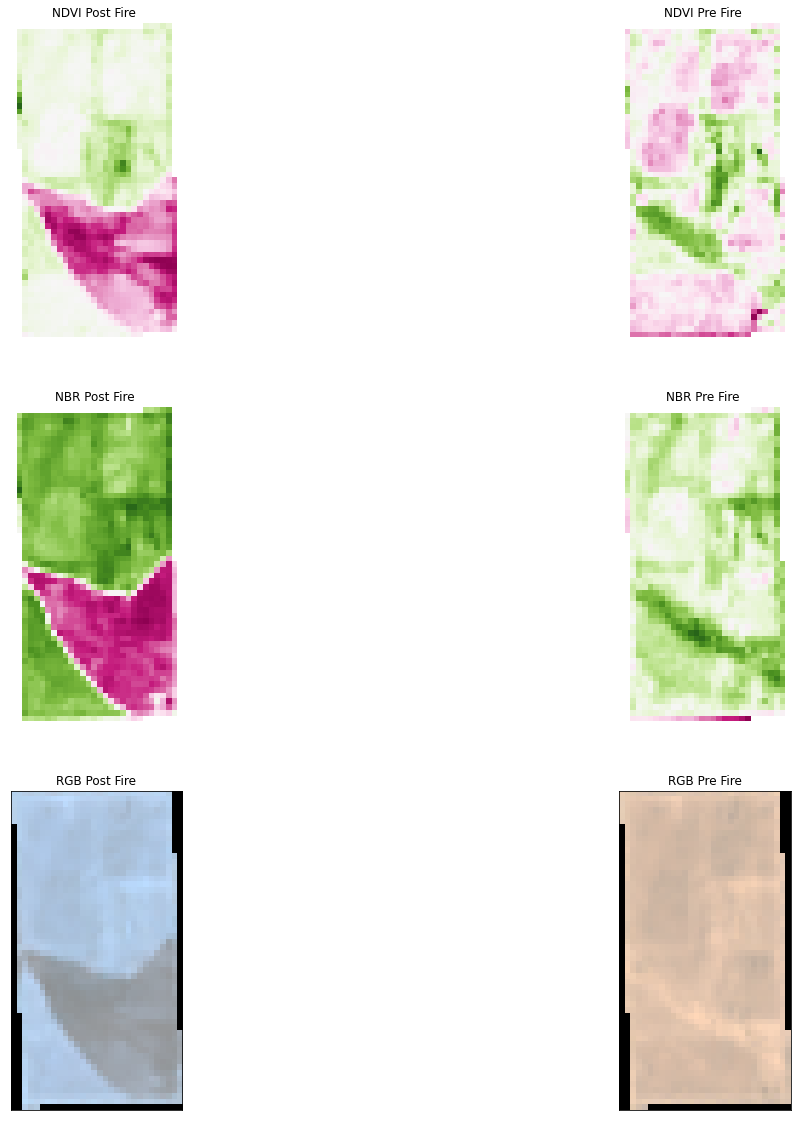

In [10]:
# PLot the data

# Add your plot code for NDVI difference here
fig, ((ax, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3,2,figsize=(20,20))

# Plot NDVI

im = ax.imshow(ndvi_plot[1],
               extent=extents,
               cmap='PiYG',)

ax.set(title="NDVI Post Fire ")
ax.set_axis_off()


im = ax1.imshow(ndvi_plot[0],
               extent=extents,
               cmap='PiYG')
ax1.set(title="NDVI Pre Fire ")
ax1.set_axis_off()

# PLot nbr

im = ax2.imshow(nbr_plot[1],
               extent=extents,
               cmap='PiYG')
ax2.set(title="NBR Post Fire ")
ax2.set_axis_off()

im = ax3.imshow(nbr_plot[0],
               extent=extents,
               cmap='PiYG')
ax3.set(title="NBR Pre Fire ")
ax3.set_axis_off()


# Plot RGB
ep.plot_rgb(rgb_plot[1], figsize=(10, 10), str_clip=2, ax=ax4,extent=extents,title='RGB Post Fire')
ep.plot_rgb(rgb_plot[0], rgb=(2, 1, 0), figsize=(10, 10), str_clip=2, ax=ax5, extent=extents, title='RGB Pre Fire')

plt.show()